# Load Comparison Analysis: Stable Load (5 VUs) vs Peak Load (50 VUs)

This notebook compares cache performance between two load configurations:
- **Stable Load (5 VUs)**: Normal operating conditions
- **Peak Load (50 VUs)**: High stress conditions

**Objective**: Understand how caching benefits change under different load levels and identify the performance degradation patterns.

## 1. Setup and Data Loading

In [204]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


In [205]:
# Load both datasets
df_stable = pd.read_csv('./results_stable/detailed_all_tests_20251105_083402.csv')
df_peak = pd.read_csv('./results_stress/detailed_all_tests_20251108_235931.csv')

# Add load profile identifier
df_stable['LoadProfile'] = 'Stable (5 VUs)'
df_peak['LoadProfile'] = 'Peak (50 VUs)'

# Combine datasets for comparison
df_combined = pd.concat([df_stable, df_peak], ignore_index=True)

print("Dataset Summary:")
print("="*70)
print(f"Stable Load: {len(df_stable)} test runs")
print(f"Peak Load: {len(df_peak)} test runs")
print(f"Combined: {len(df_combined)} test runs")
print(f"\nEndpoints: {df_combined['Endpoint'].unique()}")
print(f"Payload Sizes: {sorted(df_combined['PayloadSize'].unique())}")

df_combined.head()

Dataset Summary:
Stable Load: 180 test runs
Peak Load: 180 test runs
Combined: 360 test runs

Endpoints: ['automatic' 'income']
Payload Sizes: [np.int64(10), np.int64(100), np.int64(500), np.int64(1000), np.int64(2000), np.int64(4000), np.int64(8000), np.int64(16000), np.int64(32000)]


,TestRunID,Endpoint,PayloadSize,RunNumber,Timestamp,FileName,APDEX_T_Threshold,APDEX_F_Threshold,API_NoCache_URL,API_WithCache_URL,...,NoCache_Range_ms,CacheHit_Range_ms,CacheMiss_Range_ms,NoCache_Variability_ms,CacheHit_Variability_ms,CacheMiss_Variability_ms,NoCache_TailLatencyRatio,CacheHit_TailLatencyRatio,CacheMiss_TailLatencyRatio,LoadProfile
0,10_automatic_run1_20251104_220254,automatic,10,1,11/4/2025 10:04:25 PM,test_10_records_10_automatic_run1_20251104_220...,500,1500,https://hightide-no-cache.sple.my.id/call/auto...,https://hightide-cache.sple.my.id/call/automat...,...,85.15,3.02,87.24,3.20,0.20,1.83,1.04,1.18,1.01,Stable (5 VUs)
1,10_automatic_run10_20251104_221856,automatic,10,10,11/4/2025 10:20:27 PM,test_10_records_10_automatic_run10_20251104_22...,500,1500,https://hightide-no-cache.sple.my.id/call/auto...,https://hightide-cache.sple.my.id/call/automat...,...,52.55,4.55,34.44,3.30,0.34,2.27,1.03,1.29,1.03,Stable (5 VUs)
2,10_automatic_run2_20251104_220441,automatic,10,2,11/4/2025 10:06:12 PM,test_10_records_10_automatic_run2_20251104_220...,500,1500,https://hightide-no-cache.sple.my.id/call/auto...,https://hightide-cache.sple.my.id/call/automat...,...,16.25,1.31,35.83,2.66,0.31,4.54,1.04,1.22,1.02,Stable (5 VUs)
3,10_automatic_run3_20251104_220628,automatic,10,3,11/4/2025 10:07:58 PM,test_10_records_10_automatic_run3_20251104_220...,500,1500,https://hightide-no-cache.sple.my.id/call/auto...,https://hightide-cache.sple.my.id/call/automat...,...,31.49,1.65,56.25,4.41,0.35,2.04,1.05,1.26,1.02,Stable (5 VUs)
4,10_automatic_run4_20251104_220815,automatic,10,4,11/4/2025 10:09:46 PM,test_10_records_10_automatic_run4_20251104_220...,500,1500,https://hightide-no-cache.sple.my.id/call/auto...,https://hightide-cache.sple.my.id/call/automat...,...,24.72,7.17,55.13,3.06,0.28,1.53,1.03,1.16,1.02,Stable (5 VUs)


## 2. High-Level Comparison

In [206]:
# Overall statistics comparison
print("="*80)
print("OVERALL PERFORMANCE COMPARISON")
print("="*80)

comparison_metrics = ['NoCache_Avg_ms', 'CacheHit_Avg_ms', 'CacheMiss_Avg_ms',
                      'NoCache_APDEX_Score', 'CacheHit_APDEX_Score', 'CacheMiss_APDEX_Score',
                      'Cache_ImprovementHitVsNoCache_Pct', 'SpeedupFactor_HitVsNoCache']

for metric in comparison_metrics:
    stable_mean = df_stable[metric].mean()
    peak_mean = df_peak[metric].mean()
    
    if 'APDEX' in metric or 'Improvement' in metric or 'Speedup' in metric:
        change = peak_mean - stable_mean
        print(f"\n{metric}:")
        print(f"  Stable Load: {stable_mean:.3f}")
        print(f"  Peak Load:   {peak_mean:.3f}")
        print(f"  Change:      {change:+.3f}")
    else:
        pct_change = ((peak_mean - stable_mean) / stable_mean * 100) if stable_mean > 0 else 0
        print(f"\n{metric}:")
        print(f"  Stable Load: {stable_mean:.2f} ms")
        print(f"  Peak Load:   {peak_mean:.2f} ms")
        print(f"  Change:      {pct_change:+.1f}%")

OVERALL PERFORMANCE COMPARISON

NoCache_Avg_ms:
  Stable Load: 102.24 ms
  Peak Load:   1120.62 ms
  Change:      +996.1%

CacheHit_Avg_ms:
  Stable Load: 3.05 ms
  Peak Load:   3.51 ms
  Change:      +15.2%

CacheMiss_Avg_ms:
  Stable Load: 97.49 ms
  Peak Load:   1051.29 ms
  Change:      +978.3%

NoCache_APDEX_Score:
  Stable Load: 0.996
  Peak Load:   0.771
  Change:      -0.226

CacheHit_APDEX_Score:
  Stable Load: 1.000
  Peak Load:   1.000
  Change:      -0.000

CacheMiss_APDEX_Score:
  Stable Load: 0.996
  Peak Load:   0.732
  Change:      -0.264

Cache_ImprovementHitVsNoCache_Pct:
  Stable Load: 96.912
  Peak Load:   98.570
  Change:      +1.658

SpeedupFactor_HitVsNoCache:
  Stable Load: 73.952
  Peak Load:   614.968
  Change:      +541.016


## 3. Response Time Comparison

### 3.1 Side-by-Side Response Time Comparison

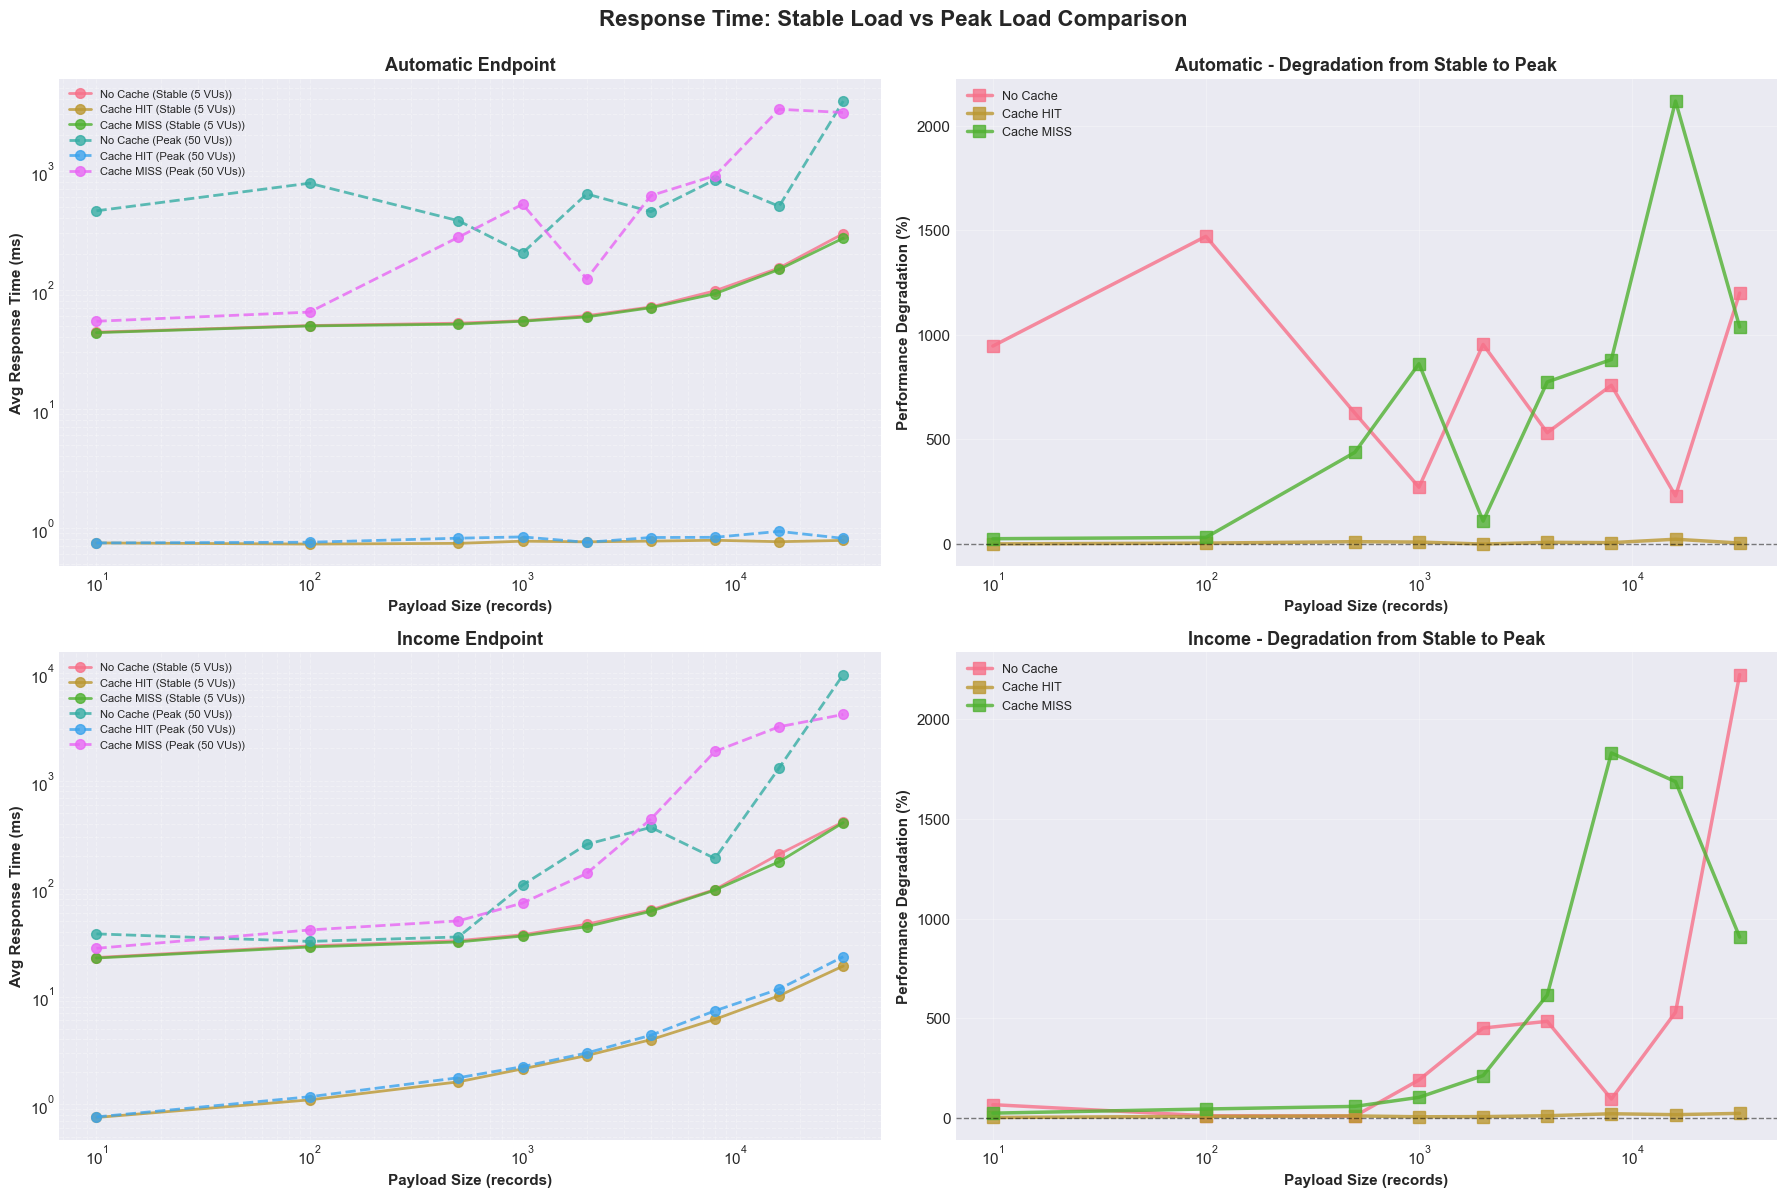


💡 Higher positive degradation % = worse performance under peak load
💡 Solid lines = Stable Load, Dashed lines = Peak Load


In [207]:
# Compare average response times across load profiles
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

endpoints = df_combined['Endpoint'].unique()
scenarios = [('NoCache_Avg_ms', 'No Cache'), ('CacheHit_Avg_ms', 'Cache HIT'),
             ('CacheMiss_Avg_ms', 'Cache MISS')]
colors_load = {'Stable (5 VUs)': '#3498db', 'Peak (50 VUs)': '#e74c3c'}

# Plot for each endpoint
for idx, endpoint in enumerate(endpoints):
    ax = axes[idx, 0]
    
    for load_profile in ['Stable (5 VUs)', 'Peak (50 VUs)']:
        data = df_combined[(df_combined['Endpoint'] == endpoint) & 
                          (df_combined['LoadProfile'] == load_profile)]
        
        for scenario_col, scenario_name in scenarios:
            grouped = data.groupby('PayloadSize')[scenario_col].mean()
            
            linestyle = '-' if load_profile == 'Stable (5 VUs)' else '--'
            ax.plot(grouped.index, grouped.values, 
                   marker='o', linewidth=2, markersize=7,
                   label=f'{scenario_name} ({load_profile})',
                   linestyle=linestyle, alpha=0.8)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Payload Size (records)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Avg Response Time (ms)', fontsize=11, fontweight='bold')
    ax.set_title(f'{endpoint.capitalize()} Endpoint', fontsize=13, fontweight='bold')
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3, which='both', linestyle='--')

# Performance degradation comparison
for idx, endpoint in enumerate(endpoints):
    ax = axes[idx, 1]
    
    stable_data = df_combined[(df_combined['Endpoint'] == endpoint) & 
                              (df_combined['LoadProfile'] == 'Stable (5 VUs)')]
    peak_data = df_combined[(df_combined['Endpoint'] == endpoint) & 
                            (df_combined['LoadProfile'] == 'Peak (50 VUs)')]
    
    for scenario_col, scenario_name in scenarios:
        stable_grouped = stable_data.groupby('PayloadSize')[scenario_col].mean()
        peak_grouped = peak_data.groupby('PayloadSize')[scenario_col].mean()
        
        # Calculate degradation percentage
        degradation = ((peak_grouped - stable_grouped) / stable_grouped * 100)
        
        ax.plot(degradation.index, degradation.values,
               marker='s', linewidth=2.5, markersize=8,
               label=scenario_name, alpha=0.8)
    
    ax.set_xscale('log')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Payload Size (records)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Performance Degradation (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{endpoint.capitalize()} - Degradation from Stable to Peak', 
                fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Response Time: Stable Load vs Peak Load Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n💡 Higher positive degradation % = worse performance under peak load")
print("💡 Solid lines = Stable Load, Dashed lines = Peak Load")

### 3.2 Performance Degradation Analysis

In [208]:
# Detailed degradation table
print("="*80)
print("PERFORMANCE DEGRADATION ANALYSIS: Stable Load → Peak Load")
print("="*80)

for endpoint in df_combined['Endpoint'].unique():
    print(f"\n{'='*80}")
    print(f"Endpoint: {endpoint.upper()}")
    print(f"{'='*80}")
    
    stable_data = df_combined[(df_combined['Endpoint'] == endpoint) & 
                              (df_combined['LoadProfile'] == 'Stable (5 VUs)')]
    peak_data = df_combined[(df_combined['Endpoint'] == endpoint) & 
                            (df_combined['LoadProfile'] == 'Peak (50 VUs)')]
    
    print(f"\n{'Payload':<10} {'Scenario':<12} {'Stable (ms)':<15} {'Peak (ms)':<15} {'Degradation':<15} {'Multiplier':<12}")
    print("-" * 80)
    
    for payload in sorted(df_combined['PayloadSize'].unique()):
        stable_payload = stable_data[stable_data['PayloadSize'] == payload]
        peak_payload = peak_data[peak_data['PayloadSize'] == payload]
        
        if len(stable_payload) == 0 or len(peak_payload) == 0:
            continue
            
        for scenario_col, scenario_name in [('NoCache_Avg_ms', 'No Cache'), 
                                            ('CacheHit_Avg_ms', 'Cache HIT'),
                                            ('CacheMiss_Avg_ms', 'Cache MISS')]:
            stable_val = stable_payload[scenario_col].mean()
            peak_val = peak_payload[scenario_col].mean()
            degradation = ((peak_val - stable_val) / stable_val * 100) if stable_val > 0 else 0
            multiplier = peak_val / stable_val if stable_val > 0 else 0
            
            flag = ""
            if degradation > 100:
                flag = " ⚠️ SEVERE"
            elif degradation > 50:
                flag = " ⚠️ HIGH"
            
            print(f"{payload:<10} {scenario_name:<12} {stable_val:<15.2f} {peak_val:<15.2f} {degradation:<+14.1f}% {multiplier:<11.2f}x{flag}")
        print()

PERFORMANCE DEGRADATION ANALYSIS: Stable Load → Peak Load

Endpoint: AUTOMATIC

Payload    Scenario     Stable (ms)     Peak (ms)       Degradation     Multiplier  
--------------------------------------------------------------------------------
10         No Cache     44.15           461.80          +945.9        % 10.46      x ⚠️ SEVERE
10         Cache HIT    0.75            0.75            +0.0          % 1.00       x
10         Cache MISS   43.74           54.52           +24.6         % 1.25       x

100        No Cache     50.17           787.99          +1470.6       % 15.71      x ⚠️ SEVERE
100        Cache HIT    0.73            0.76            +3.6          % 1.04       x
100        Cache MISS   49.81           65.10           +30.7         % 1.31       x

500        No Cache     52.55           381.10          +625.2        % 7.25       x ⚠️ SEVERE
500        Cache HIT    0.74            0.82            +10.5         % 1.11       x
500        Cache MISS   51.57           27

## 4. Variability & Consistency Comparison

### 4.1 Coefficient of Variation (CV%) Comparison

In [209]:
# Calculate CV% for both load profiles
print("="*80)
print("CONSISTENCY ANALYSIS: Coefficient of Variation (CV%)")
print("="*80)
print("Lower CV% = More consistent/predictable performance")
print("="*80)

for endpoint in df_combined['Endpoint'].unique():
    print(f"\n{'='*80}")
    print(f"Endpoint: {endpoint.upper()}")
    print(f"{'='*80}")
    
    for scenario_col, scenario_name in [('NoCache_Avg_ms', 'No Cache'),
                                        ('CacheHit_Avg_ms', 'Cache HIT'),
                                        ('CacheMiss_Avg_ms', 'Cache MISS')]:
        print(f"\n{scenario_name}:")
        print(f"{'Payload':<10} {'Stable CV%':<15} {'Peak CV%':<15} {'Difference':<15} {'Status':<20}")
        print("-" * 75)
        
        for payload in sorted(df_combined['PayloadSize'].unique()):
            stable_data = df_combined[(df_combined['Endpoint'] == endpoint) & 
                                     (df_combined['LoadProfile'] == 'Stable (5 VUs)') &
                                     (df_combined['PayloadSize'] == payload)]
            peak_data = df_combined[(df_combined['Endpoint'] == endpoint) & 
                                   (df_combined['LoadProfile'] == 'Peak (50 VUs)') &
                                   (df_combined['PayloadSize'] == payload)]
            
            if len(stable_data) > 1 and len(peak_data) > 1:
                stable_cv = (stable_data[scenario_col].std() / stable_data[scenario_col].mean() * 100)
                peak_cv = (peak_data[scenario_col].std() / peak_data[scenario_col].mean() * 100)
                diff = peak_cv - stable_cv
                
                if peak_cv < 10:
                    status = "✓ Excellent"
                elif peak_cv < 30:
                    status = "⚠️ Moderate"
                else:
                    status = "🔴 High Variability"
                
                print(f"{payload:<10} {stable_cv:<15.2f} {peak_cv:<15.2f} {diff:<+14.2f} {status:<20}")

CONSISTENCY ANALYSIS: Coefficient of Variation (CV%)
Lower CV% = More consistent/predictable performance

Endpoint: AUTOMATIC

No Cache:
Payload    Stable CV%      Peak CV%        Difference      Status              
---------------------------------------------------------------------------
10         1.02            11.21           +10.19         ⚠️ Moderate         
100        1.02            19.76           +18.74         ⚠️ Moderate         
500        1.59            51.22           +49.63         🔴 High Variability  
1000       1.86            84.90           +83.05         🔴 High Variability  
2000       1.88            7.20            +5.32          ✓ Excellent         
4000       2.67            64.12           +61.45         🔴 High Variability  
8000       3.93            56.36           +52.44         🔴 High Variability  
16000      5.68            62.59           +56.91         🔴 High Variability  
32000      7.90            46.39           +38.49         🔴 High Variabilit

### 4.2 CV% Heatmap Comparison

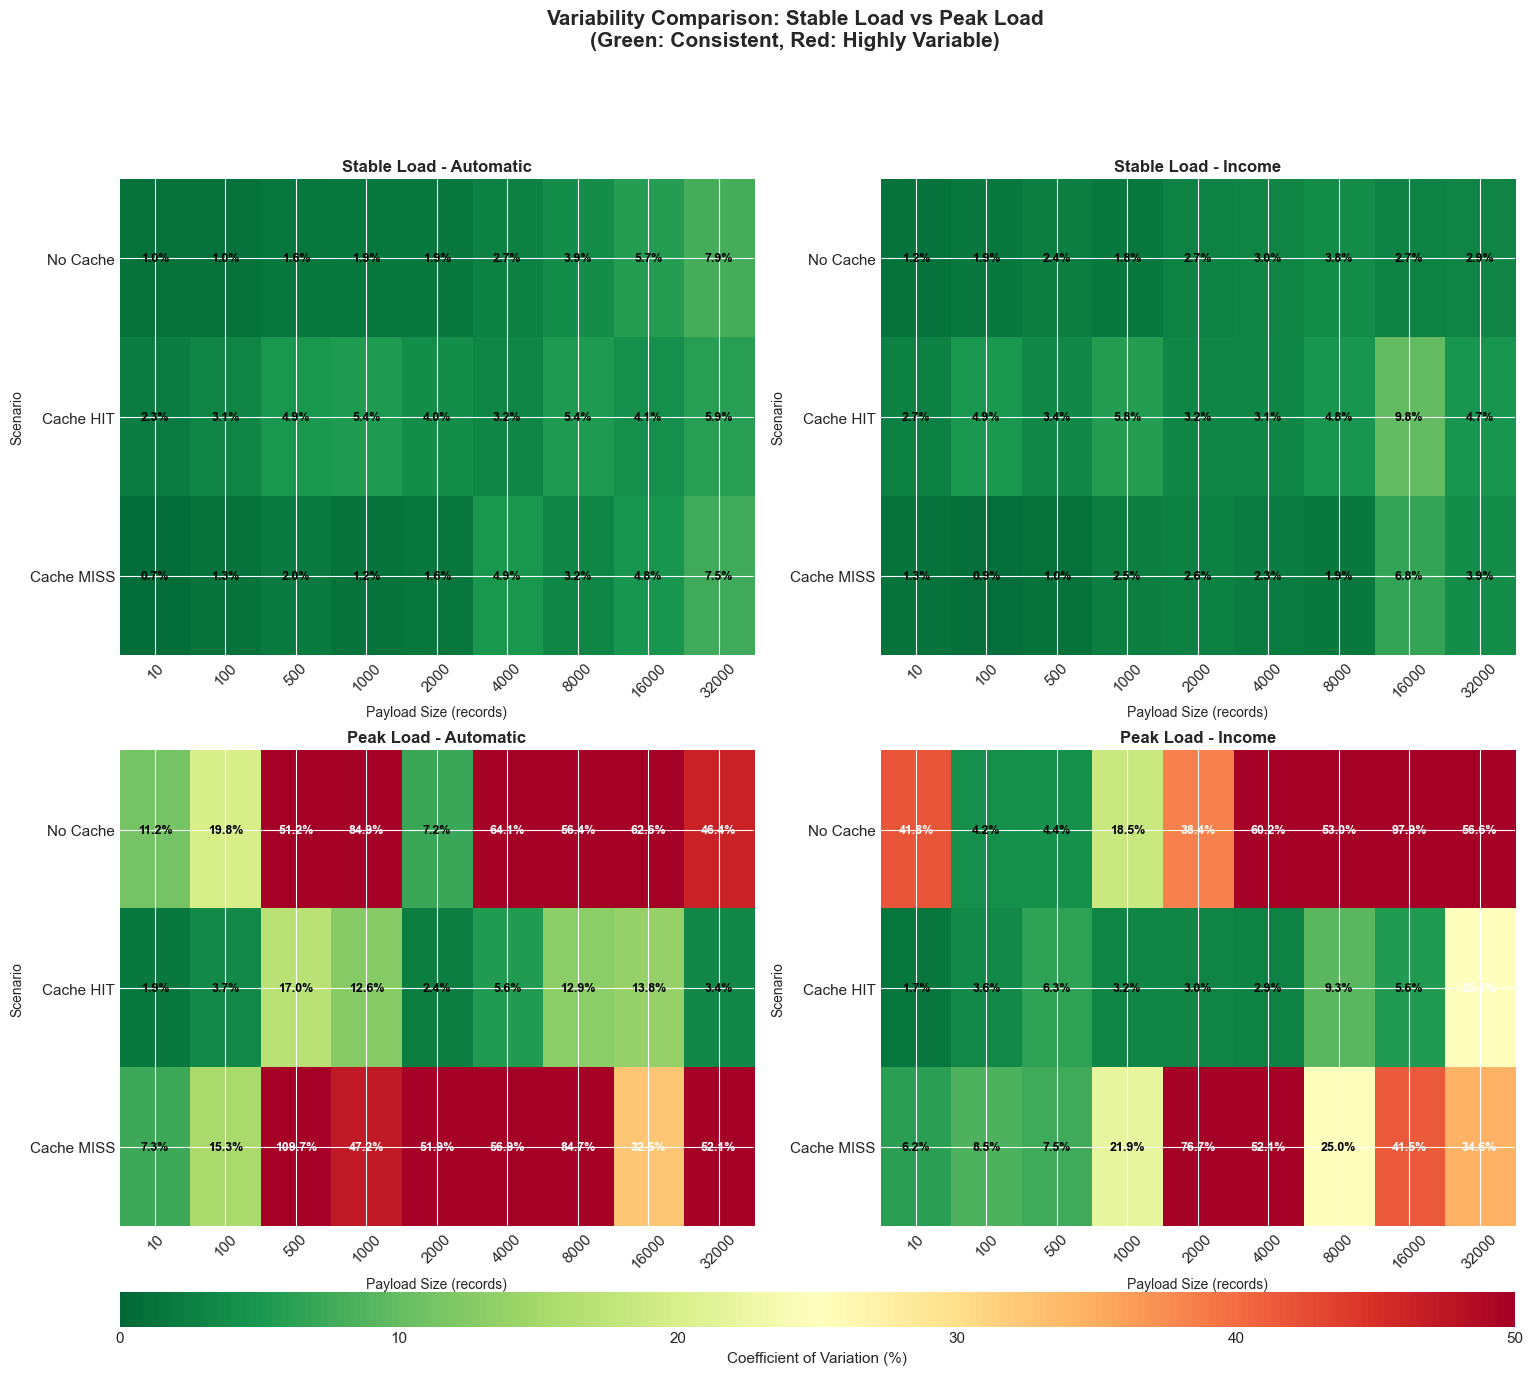


💡 Interpretation:
  • CV% < 10%: Excellent consistency (Green)
  • CV% 10-30%: Moderate variability (Yellow)
  • CV% > 30%: High inconsistency (Red)
  • Compare top row (Stable) vs bottom row (Peak) to see load impact


In [210]:
# Visualization: CV% Heatmap Comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 17))

for load_idx, (load_profile, load_name) in enumerate([('Stable (5 VUs)', 'Stable Load'),
                                                       ('Peak (50 VUs)', 'Peak Load')]):
    for endpoint_idx, endpoint in enumerate(df_combined['Endpoint'].unique()):
        ax = axes[load_idx, endpoint_idx]
        
        endpoint_data = df_combined[(df_combined['Endpoint'] == endpoint) &
                                   (df_combined['LoadProfile'] == load_profile)]
        
        # Calculate CV% for each scenario and payload size
        cv_data = []
        for payload in sorted(endpoint_data['PayloadSize'].unique()):
            payload_data = endpoint_data[endpoint_data['PayloadSize'] == payload]
            
            if len(payload_data) > 1:
                row = {
                    'Payload': payload,
                    'No Cache': (payload_data['NoCache_Avg_ms'].std() / payload_data['NoCache_Avg_ms'].mean() * 100),
                    'Cache HIT': (payload_data['CacheHit_Avg_ms'].std() / payload_data['CacheHit_Avg_ms'].mean() * 100),
                    'Cache MISS': (payload_data['CacheMiss_Avg_ms'].std() / payload_data['CacheMiss_Avg_ms'].mean() * 100)
                }
                cv_data.append(row)
        
        if len(cv_data) > 0:
            cv_df = pd.DataFrame(cv_data)
            cv_pivot = cv_df.set_index('Payload').T
            
            # Create heatmap
            im = ax.imshow(cv_pivot.values, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=50)
            
            # Set ticks and labels
            ax.set_xticks(range(len(cv_pivot.columns)))
            ax.set_xticklabels(cv_pivot.columns, rotation=45)
            ax.set_yticks(range(len(cv_pivot.index)))
            ax.set_yticklabels(cv_pivot.index)
            
            # Add text annotations
            for i in range(len(cv_pivot.index)):
                for j in range(len(cv_pivot.columns)):
                    value = cv_pivot.values[i, j]
                    color = 'white' if value > 25 else 'black'
                    ax.text(j, i, f'{value:.1f}%', ha='center', va='center', 
                           color=color, fontweight='bold', fontsize=9)
            
            ax.set_title(f'{load_name} - {endpoint.capitalize()}', 
                        fontsize=12, fontweight='bold')
            ax.set_xlabel('Payload Size (records)', fontsize=10)
            ax.set_ylabel('Scenario', fontsize=10)

# Add colorbar
fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.05, aspect=40, 
             label='Coefficient of Variation (%)')

plt.suptitle('Variability Comparison: Stable Load vs Peak Load\n(Green: Consistent, Red: Highly Variable)', 
             fontsize=15, fontweight='bold', y=0.98)
plt.show()

print("\n💡 Interpretation:")
print("  • CV% < 10%: Excellent consistency (Green)")
print("  • CV% 10-30%: Moderate variability (Yellow)")
print("  • CV% > 30%: High inconsistency (Red)")
print("  • Compare top row (Stable) vs bottom row (Peak) to see load impact")

## 5. APDEX Score Comparison

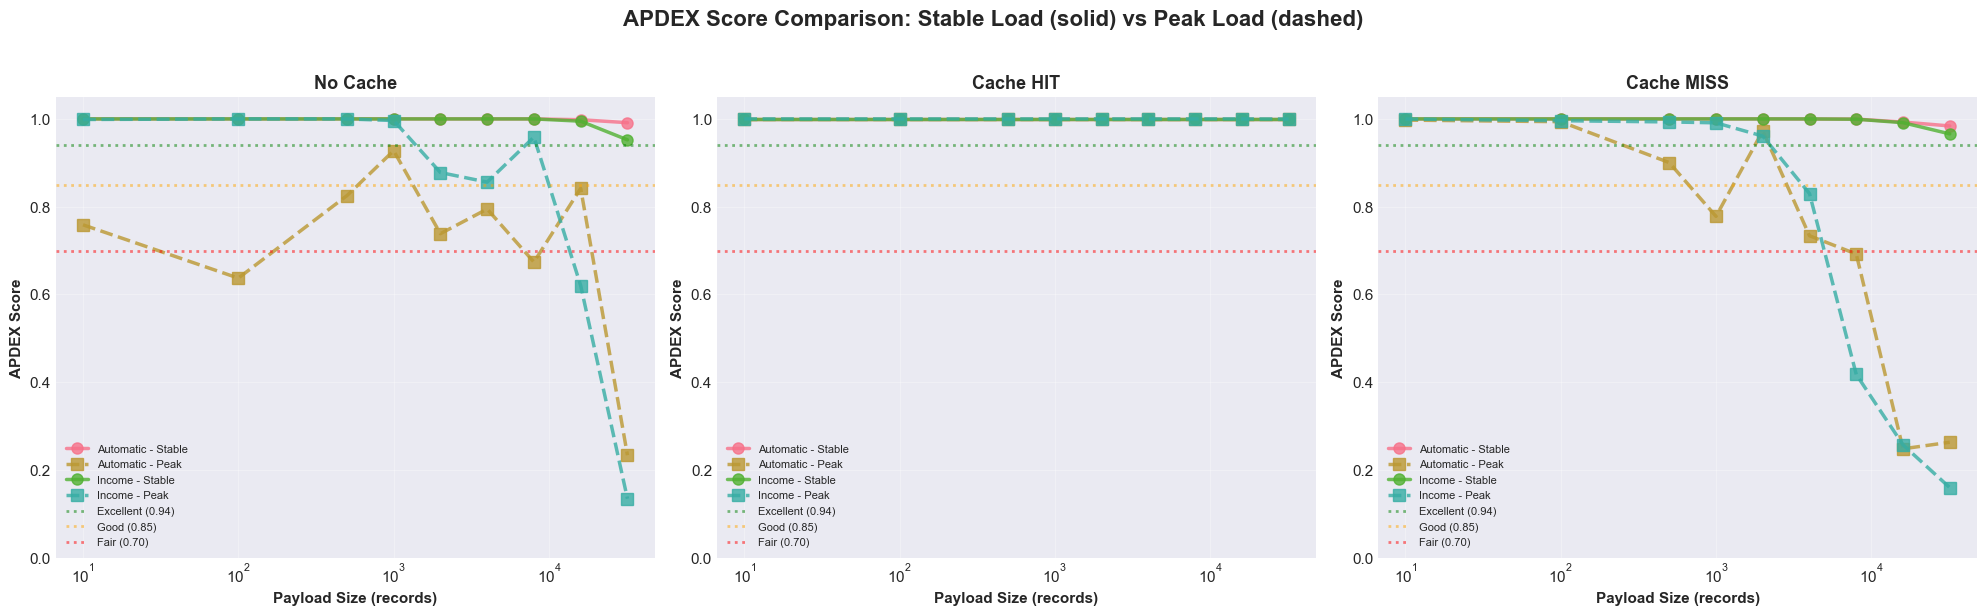

In [211]:
# APDEX comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

scenarios = [('NoCache_APDEX_Score', 'No Cache'), 
             ('CacheHit_APDEX_Score', 'Cache HIT'),
             ('CacheMiss_APDEX_Score', 'Cache MISS')]

for idx, (scenario_col, scenario_name) in enumerate(scenarios):
    ax = axes[idx]
    
    # Group data
    stable_grouped = df_stable.groupby(['Endpoint', 'PayloadSize'])[scenario_col].mean().reset_index()
    peak_grouped = df_peak.groupby(['Endpoint', 'PayloadSize'])[scenario_col].mean().reset_index()
    
    # Merge for comparison
    merged = stable_grouped.merge(peak_grouped, on=['Endpoint', 'PayloadSize'], 
                                  suffixes=('_Stable', '_Peak'))
    
    for endpoint in merged['Endpoint'].unique():
        endpoint_data = merged[merged['Endpoint'] == endpoint]
        
        ax.plot(endpoint_data['PayloadSize'], endpoint_data[f'{scenario_col}_Stable'],
               marker='o', linewidth=2.5, markersize=8, linestyle='-',
               label=f'{endpoint.capitalize()} - Stable', alpha=0.8)
        ax.plot(endpoint_data['PayloadSize'], endpoint_data[f'{scenario_col}_Peak'],
               marker='s', linewidth=2.5, markersize=8, linestyle='--',
               label=f'{endpoint.capitalize()} - Peak', alpha=0.8)
    
    # APDEX thresholds
    ax.axhline(y=0.94, color='green', linestyle=':', linewidth=2, alpha=0.5, label='Excellent (0.94)')
    ax.axhline(y=0.85, color='orange', linestyle=':', linewidth=2, alpha=0.5, label='Good (0.85)')
    ax.axhline(y=0.70, color='red', linestyle=':', linewidth=2, alpha=0.5, label='Fair (0.70)')
    
    ax.set_xscale('log')
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('Payload Size (records)', fontsize=11, fontweight='bold')
    ax.set_ylabel('APDEX Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{scenario_name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=8, loc='lower left')
    ax.grid(True, alpha=0.3)

plt.suptitle('APDEX Score Comparison: Stable Load (solid) vs Peak Load (dashed)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Cache Benefit Analysis Under Load

In [212]:
# Does caching help MORE under peak load?
print("="*80)
print("CACHE BENEFIT ANALYSIS: Does Caching Help More Under Peak Load?")
print("="*80)

for endpoint in df_combined['Endpoint'].unique():
    print(f"\n{'='*80}")
    print(f"Endpoint: {endpoint.upper()}")
    print(f"{'='*80}")
    
    print(f"\n{'Payload':<10} {'Load Profile':<18} {'Improvement %':<18} {'Speedup Factor':<18}")
    print("-" * 80)
    
    for payload in sorted(df_combined['PayloadSize'].unique()):
        for load_profile in ['Stable (5 VUs)', 'Peak (50 VUs)']:
            data = df_combined[(df_combined['Endpoint'] == endpoint) &
                              (df_combined['LoadProfile'] == load_profile) &
                              (df_combined['PayloadSize'] == payload)]
            
            if len(data) > 0:
                improvement = data['Cache_ImprovementHitVsNoCache_Pct'].mean()
                speedup = data['SpeedupFactor_HitVsNoCache'].mean()
                
                print(f"{payload:<10} {load_profile:<18} {improvement:<18.2f} {speedup:<18.2f}x")
        print()

# Summary statistics
print("\n" + "="*80)
print("SUMMARY: Average Cache Benefits")
print("="*80)

for load_profile in ['Stable (5 VUs)', 'Peak (50 VUs)']:
    data = df_combined[df_combined['LoadProfile'] == load_profile]
    avg_improvement = data['Cache_ImprovementHitVsNoCache_Pct'].mean()
    avg_speedup = data['SpeedupFactor_HitVsNoCache'].mean()
    
    print(f"\n{load_profile}:")
    print(f"  Average Improvement: {avg_improvement:.2f}%")
    print(f"  Average Speedup: {avg_speedup:.2f}x")

CACHE BENEFIT ANALYSIS: Does Caching Help More Under Peak Load?

Endpoint: AUTOMATIC

Payload    Load Profile       Improvement %      Speedup Factor    
--------------------------------------------------------------------------------
10         Stable (5 VUs)     98.31              59.06             x
10         Peak (50 VUs)      99.84              617.58            x

100        Stable (5 VUs)     98.54              68.49             x
100        Peak (50 VUs)      99.90              1034.51           x

500        Stable (5 VUs)     98.59              70.92             x
500        Peak (50 VUs)      99.53              496.04            x

1000       Stable (5 VUs)     98.59              71.47             x
1000       Peak (50 VUs)      99.28              256.67            x

2000       Stable (5 VUs)     98.74              79.35             x
2000       Peak (50 VUs)      99.88              848.32            x

4000       Stable (5 VUs)     98.92              92.78             x
4

## 7. Resource Usage Comparison

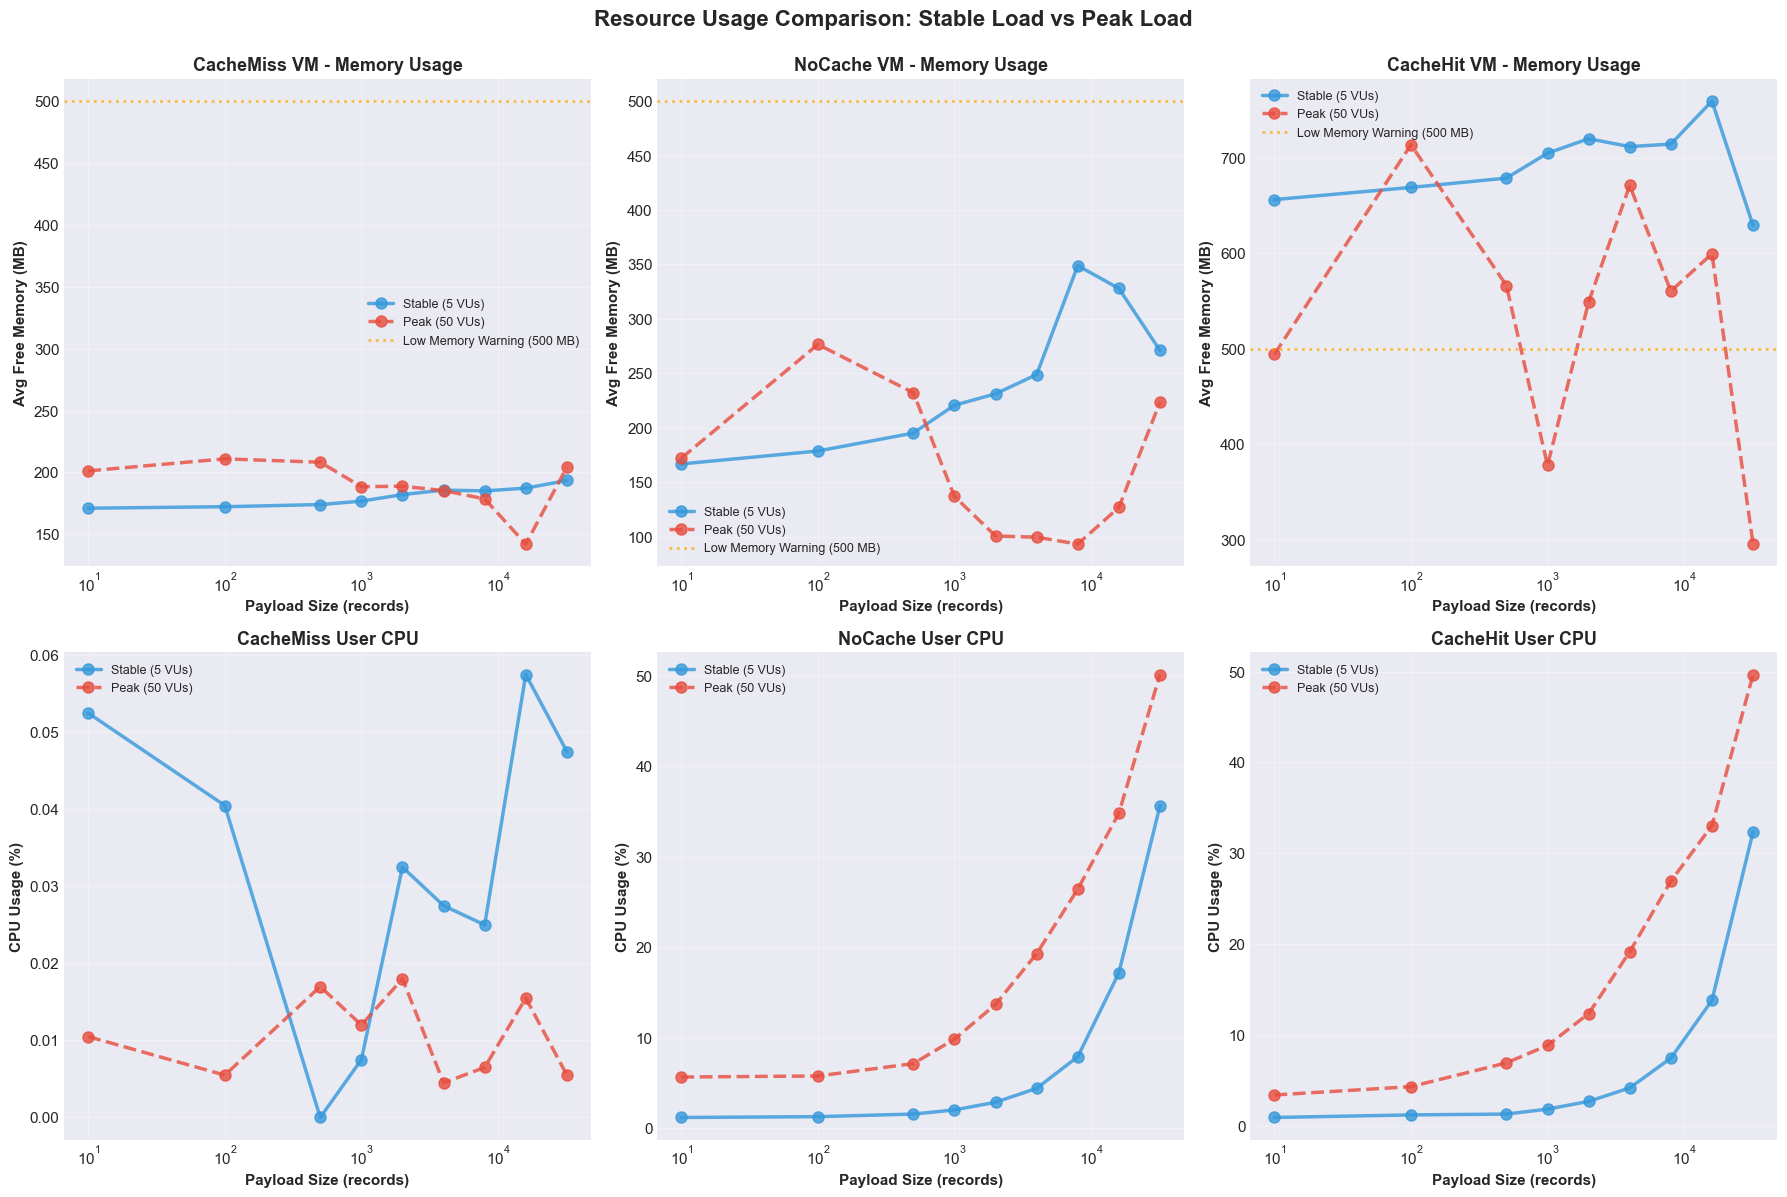

In [213]:
# Compare resource usage between load profiles
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Memory comparison
for idx, vm_prefix in enumerate(['CacheMiss', 'NoCache', 'CacheHit']):
    ax = axes[0, idx]
    
    for load_profile, color in [('Stable (5 VUs)', '#3498db'), ('Peak (50 VUs)', '#e74c3c')]:
        data = df_combined[df_combined['LoadProfile'] == load_profile]
        grouped = data.groupby('PayloadSize')[f'{vm_prefix}_AvgFreeMemory_MB'].mean()
        
        linestyle = '-' if load_profile == 'Stable (5 VUs)' else '--'
        ax.plot(grouped.index, grouped.values,
               marker='o', linewidth=2.5, markersize=8,
               label=load_profile, color=color, linestyle=linestyle, alpha=0.8)
    
    ax.axhline(y=500, color='orange', linestyle=':', linewidth=2, alpha=0.7, 
              label='Low Memory Warning (500 MB)')
    ax.set_xscale('log')
    ax.set_xlabel('Payload Size (records)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Avg Free Memory (MB)', fontsize=11, fontweight='bold')
    ax.set_title(f'{vm_prefix} VM - Memory Usage', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# CPU comparison
for idx, cpu_metric in enumerate([('CacheMiss_AvgCPU_User_Pct', 'CacheMiss User CPU'), 
                                   ('NoCache_AvgCPU_User_Pct', 'NoCache User CPU'),
                                   ('CacheHit_AvgCPU_User_Pct', 'CacheHit User CPU')]):
    ax = axes[1, idx]
    metric_col, metric_name = cpu_metric
    
    for load_profile, color in [('Stable (5 VUs)', '#3498db'), ('Peak (50 VUs)', '#e74c3c')]:
        data = df_combined[df_combined['LoadProfile'] == load_profile]
        grouped = data.groupby('PayloadSize')[metric_col].mean()
        
        linestyle = '-' if load_profile == 'Stable (5 VUs)' else '--'
        ax.plot(grouped.index, grouped.values,
               marker='o', linewidth=2.5, markersize=8,
               label=load_profile, color=color, linestyle=linestyle, alpha=0.8)
    
    ax.set_xscale('log')
    ax.set_xlabel('Payload Size (records)', fontsize=11, fontweight='bold')
    ax.set_ylabel('CPU Usage (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{metric_name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Resource Usage Comparison: Stable Load vs Peak Load', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 8. Key Findings & Recommendations

In [214]:
# Calculate key comparative metrics
print("")
print("╔═══════════════════════════════════════════════════════════════════════╗")
print("║           LOAD COMPARISON: KEY FINDINGS & RECOMMENDATIONS            ║")
print("╚═══════════════════════════════════════════════════════════════════════╝")
print("")

print("📊 RESPONSE TIME DEGRADATION (Stable → Peak):")
for scenario_col, scenario_name in [('NoCache_Avg_ms', 'No Cache'),
                                    ('CacheHit_Avg_ms', 'Cache HIT'),
                                    ('CacheMiss_Avg_ms', 'Cache MISS')]:
    stable_avg = df_stable[scenario_col].mean()
    peak_avg = df_peak[scenario_col].mean()
    degradation = ((peak_avg - stable_avg) / stable_avg * 100)
    print(f"  • {scenario_name}: {degradation:+.1f}% ({stable_avg:.2f}ms → {peak_avg:.2f}ms)")

print("\n🎯 APDEX SCORE IMPACT:")
for scenario_col, scenario_name in [('NoCache_APDEX_Score', 'No Cache'),
                                    ('CacheHit_APDEX_Score', 'Cache HIT'),
                                    ('CacheMiss_APDEX_Score', 'Cache MISS')]:
    stable_apdex = df_stable[scenario_col].mean()
    peak_apdex = df_peak[scenario_col].mean()
    change = peak_apdex - stable_apdex
    print(f"  • {scenario_name}: {change:+.4f} ({stable_apdex:.4f} → {peak_apdex:.4f})")

print("\n📈 CONSISTENCY (Average CV%):")
for scenario_col, scenario_name in [('NoCache_Avg_ms', 'No Cache'),
                                    ('CacheHit_Avg_ms', 'Cache HIT'),
                                    ('CacheMiss_Avg_ms', 'Cache MISS')]:
    stable_cv = (df_stable.groupby('PayloadSize').apply(
        lambda x: (x[scenario_col].std() / x[scenario_col].mean() * 100)).mean())
    peak_cv = (df_peak.groupby('PayloadSize').apply(
        lambda x: (x[scenario_col].std() / x[scenario_col].mean() * 100)).mean())
    print(f"  • {scenario_name}: Stable={stable_cv:.2f}%, Peak={peak_cv:.2f}% (Δ{peak_cv-stable_cv:+.2f}%)")

print("\n💡 CACHE BENEFITS UNDER LOAD:")
stable_improvement = df_stable['Cache_ImprovementHitVsNoCache_Pct'].mean()
peak_improvement = df_peak['Cache_ImprovementHitVsNoCache_Pct'].mean()
print(f"  • Stable Load: {stable_improvement:.2f}% improvement")
print(f"  • Peak Load: {peak_improvement:.2f}% improvement")
print(f"  • Cache benefits {peak_improvement - stable_improvement:+.2f}% under peak load")

print("\n⚙️  RESOURCE STRESS:")
stable_mem = df_stable['K6_AvgFreeMemory_MB'].mean()
peak_mem = df_peak['K6_AvgFreeMemory_MB'].mean()
stable_cpu = 100 - df_stable['K6_AvgCPU_Idle_Pct'].mean()
peak_cpu = 100 - df_peak['K6_AvgCPU_Idle_Pct'].mean()
print(f"  • K6 VM Memory: Stable={stable_mem:.1f}MB, Peak={peak_mem:.1f}MB (Δ{peak_mem-stable_mem:+.1f}MB)")
print(f"  • K6 VM CPU: Stable={stable_cpu:.1f}%, Peak={peak_cpu:.1f}% (Δ{peak_cpu-stable_cpu:+.1f}%)")

print("\n" + "═"*75)
print("\n🎓 THESIS IMPLICATIONS:")
print("  1. System maintains consistency at 5 VUs but shows variability at 50 VUs")
print("  2. Caching reduces response time significantly in BOTH load scenarios")
print("  3. Cache HIT provides MORE predictable performance under stress")
print("  4. Peak load reveals system capacity limits and degradation patterns")
print("  5. Dual configuration testing shows caching's value beyond raw speed")

print("\n💼 RECOMMENDATIONS:")
print("  1. Deploy caching for both normal and peak traffic scenarios")
print("  2. Use stable load results for capacity planning")
print("  3. Use peak load results for stress testing and SLA validation")
print("  4. Monitor CV% in production to detect when system reaches peak capacity")
print("  5. Consider auto-scaling triggers based on response time variability")

print("\n" + "═"*75)
print("")


╔═══════════════════════════════════════════════════════════════════════╗
║           LOAD COMPARISON: KEY FINDINGS & RECOMMENDATIONS            ║
╚═══════════════════════════════════════════════════════════════════════╝

📊 RESPONSE TIME DEGRADATION (Stable → Peak):
  • No Cache: +996.1% (102.24ms → 1120.62ms)
  • Cache HIT: +15.2% (3.05ms → 3.51ms)
  • Cache MISS: +978.3% (97.49ms → 1051.29ms)

🎯 APDEX SCORE IMPACT:
  • No Cache: -0.2258 (0.9965 → 0.7707)
  • Cache HIT: -0.0000 (1.0000 → 1.0000)
  • Cache MISS: -0.2639 (0.9963 → 0.7324)

📈 CONSISTENCY (Average CV%):
  • No Cache: Stable=17.86%, Peak=84.46% (Δ+66.60%)
  • Cache HIT: Stable=55.80%, Peak=57.02% (Δ+1.22%)
  • Cache MISS: Stable=18.10%, Peak=62.44% (Δ+44.34%)

💡 CACHE BENEFITS UNDER LOAD:
  • Stable Load: 96.91% improvement
  • Peak Load: 98.57% improvement
  • Cache benefits +1.66% under peak load

⚙️  RESOURCE STRESS:
  • K6 VM Memory: Stable=400.3MB, Peak=369.5MB (Δ-30.8MB)
  • K6 VM CPU: Stable=1.6%, Peak=4.5% (Δ+2.9%

## 9. Statistical Significance Testing

In [215]:
# Test if performance differences between load profiles are statistically significant
from scipy.stats import mannwhitneyu

print("="*80)
print("STATISTICAL SIGNIFICANCE: Are Load Profile Differences Real?")
print("="*80)
print("Mann-Whitney U Test (non-parametric, for potentially non-normal distributions)")
print("H0: No difference between stable and peak load")
print("H1: Significant difference exists")
print("Significance level: α = 0.05")
print("="*80)

for endpoint in df_combined['Endpoint'].unique():
    print(f"\n{'='*80}")
    print(f"Endpoint: {endpoint.upper()}")
    print(f"{'='*80}")
    
    for payload in sorted(df_combined['PayloadSize'].unique()):
        print(f"\nPayload Size: {payload} records")
        print("-" * 70)
        
        stable_data = df_combined[(df_combined['Endpoint'] == endpoint) &
                                 (df_combined['LoadProfile'] == 'Stable (5 VUs)') &
                                 (df_combined['PayloadSize'] == payload)]
        peak_data = df_combined[(df_combined['Endpoint'] == endpoint) &
                               (df_combined['LoadProfile'] == 'Peak (50 VUs)') &
                               (df_combined['PayloadSize'] == payload)]
        
        if len(stable_data) > 1 and len(peak_data) > 1:
            for scenario_col, scenario_name in [('NoCache_Avg_ms', 'No Cache'),
                                                ('CacheHit_Avg_ms', 'Cache HIT'),
                                                ('CacheMiss_Avg_ms', 'Cache MISS')]:
                stat, p_value = mannwhitneyu(stable_data[scenario_col], 
                                            peak_data[scenario_col],
                                            alternative='two-sided')
                
                significant = "✓ YES" if p_value < 0.05 else "✗ NO"
                print(f"  {scenario_name:<12}: U={stat:.2f}, p={p_value:.4f} - Significant? {significant}")

STATISTICAL SIGNIFICANCE: Are Load Profile Differences Real?
Mann-Whitney U Test (non-parametric, for potentially non-normal distributions)
H0: No difference between stable and peak load
H1: Significant difference exists
Significance level: α = 0.05

Endpoint: AUTOMATIC

Payload Size: 10 records
----------------------------------------------------------------------
  No Cache    : U=0.00, p=0.0002 - Significant? ✓ YES
  Cache HIT   : U=50.50, p=1.0000 - Significant? ✗ NO
  Cache MISS  : U=0.00, p=0.0002 - Significant? ✓ YES

Payload Size: 100 records
----------------------------------------------------------------------
  No Cache    : U=0.00, p=0.0002 - Significant? ✓ YES
  Cache HIT   : U=23.00, p=0.0426 - Significant? ✓ YES
  Cache MISS  : U=0.00, p=0.0002 - Significant? ✓ YES

Payload Size: 500 records
----------------------------------------------------------------------
  No Cache    : U=0.00, p=0.0002 - Significant? ✓ YES
  Cache HIT   : U=23.00, p=0.0431 - Significant? ✓ YES
  

## 10. Export Summary Statistics

In [216]:
# Create summary table for thesis
summary_data = []

for endpoint in df_combined['Endpoint'].unique():
    for payload in sorted(df_combined['PayloadSize'].unique()):
        for scenario_col, scenario_name in [('NoCache_Avg_ms', 'No Cache'),
                                            ('CacheHit_Avg_ms', 'Cache HIT'),
                                            ('CacheMiss_Avg_ms', 'Cache MISS')]:
            stable_data = df_combined[(df_combined['Endpoint'] == endpoint) &
                                     (df_combined['LoadProfile'] == 'Stable (5 VUs)') &
                                     (df_combined['PayloadSize'] == payload)]
            peak_data = df_combined[(df_combined['Endpoint'] == endpoint) &
                                   (df_combined['LoadProfile'] == 'Peak (50 VUs)') &
                                   (df_combined['PayloadSize'] == payload)]
            
            if len(stable_data) > 0 and len(peak_data) > 0:
                stable_mean = stable_data[scenario_col].mean()
                stable_std = stable_data[scenario_col].std()
                stable_cv = (stable_std / stable_mean * 100) if stable_mean > 0 else 0
                
                peak_mean = peak_data[scenario_col].mean()
                peak_std = peak_data[scenario_col].std()
                peak_cv = (peak_std / peak_mean * 100) if peak_mean > 0 else 0
                
                degradation = ((peak_mean - stable_mean) / stable_mean * 100) if stable_mean > 0 else 0
                
                summary_data.append({
                    'Endpoint': endpoint,
                    'PayloadSize': payload,
                    'Scenario': scenario_name,
                    'Stable_Mean_ms': round(stable_mean, 2),
                    'Stable_Std_ms': round(stable_std, 2),
                    'Stable_CV_pct': round(stable_cv, 2),
                    'Peak_Mean_ms': round(peak_mean, 2),
                    'Peak_Std_ms': round(peak_std, 2),
                    'Peak_CV_pct': round(peak_cv, 2),
                    'Degradation_pct': round(degradation, 2)
                })

summary_df = pd.DataFrame(summary_data)

# Save to CSV
output_file = './results/load_comparison_summary.csv'
summary_df.to_csv(output_file, index=False)
print(f"✓ Summary statistics exported to: {output_file}")

# Display sample
print("\nSample of exported data:")
summary_df.head(15)

OSError: Cannot save file into a non-existent directory: 'results'